In [49]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [100]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from scipy.stats import zscore as zs
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout

In [51]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import shap

In [53]:
df= pd.read_csv("/content/COMBINED.csv")

In [54]:
df.head()

,Date,WTI,GOLD,SP 500,US DOLLAR INDEX,US 10YR BOND,DJU
0,04-01-2000,25.55,282.7,1411.75,100.10,6.499,289.10
1,05-01-2000,24.91,281.1,1413.50,100.05,6.599,292.64
2,06-01-2000,24.78,281.4,1404.00,100.34,6.540,297.70
3,07-01-2000,24.22,281.9,1460.50,100.50,6.513,NaN
4,10-01-2000,24.67,281.7,1475.00,100.65,6.554,294.37


In [55]:
df.shape

(4947, 7)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4947 non-null   object 
 1   WTI              4947 non-null   float64
 2   GOLD             4941 non-null   float64
 3   SP 500           4946 non-null   float64
 4   US DOLLAR INDEX  4917 non-null   float64
 5   US 10YR BOND     4920 non-null   float64
 6   DJU              4859 non-null   float64
dtypes: float64(6), object(1)
memory usage: 270.7+ KB


In [57]:
df.describe()

,WTI,GOLD,SP 500,US DOLLAR INDEX,US 10YR BOND,DJU
count,4947.000000,4941.000000,4946.000000,4917.000000,4920.000000,4859.000000
mean,62.068803,943.852311,1544.704848,90.503182,3.453490,459.169801
std,26.470270,473.656860,544.716725,11.691564,1.222532,147.334229
min,17.450000,255.100000,676.000000,71.304000,1.358000,167.570007
25%,40.115000,424.000000,1150.250000,80.946000,2.382000,359.664994
50%,59.300000,1088.500000,1356.250000,88.350000,3.389500,438.119995
75%,83.725000,1329.800000,1945.687500,96.940000,4.413000,553.309998
max,145.290000,1888.700000,2948.500000,121.210000,6.790000,812.909973


In [58]:
df.isnull().sum()

Date                0
WTI                 0
GOLD                6
SP 500              1
US DOLLAR INDEX    30
US 10YR BOND       27
DJU                88
dtype: int64

In [59]:
#filling null value with previous day value
df2= df.fillna(method='ffill')
df2.isnull().sum()

Date               0
WTI                0
GOLD               0
SP 500             0
US DOLLAR INDEX    0
US 10YR BOND       0
DJU                0
dtype: int64

In [60]:
df2['Date'] = pd.to_datetime(df2['Date'],format='%d-%m-%Y')
df2.set_index('Date',inplace=True)
df2.head(2)

,WTI,GOLD,SP 500,US DOLLAR INDEX,US 10YR BOND,DJU
Date,,,,,,
2000-01-04,25.55,282.7,1411.75,100.10,6.499,289.10
2000-01-05,24.91,281.1,1413.50,100.05,6.599,292.64


## **EDA:** ##

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Ple

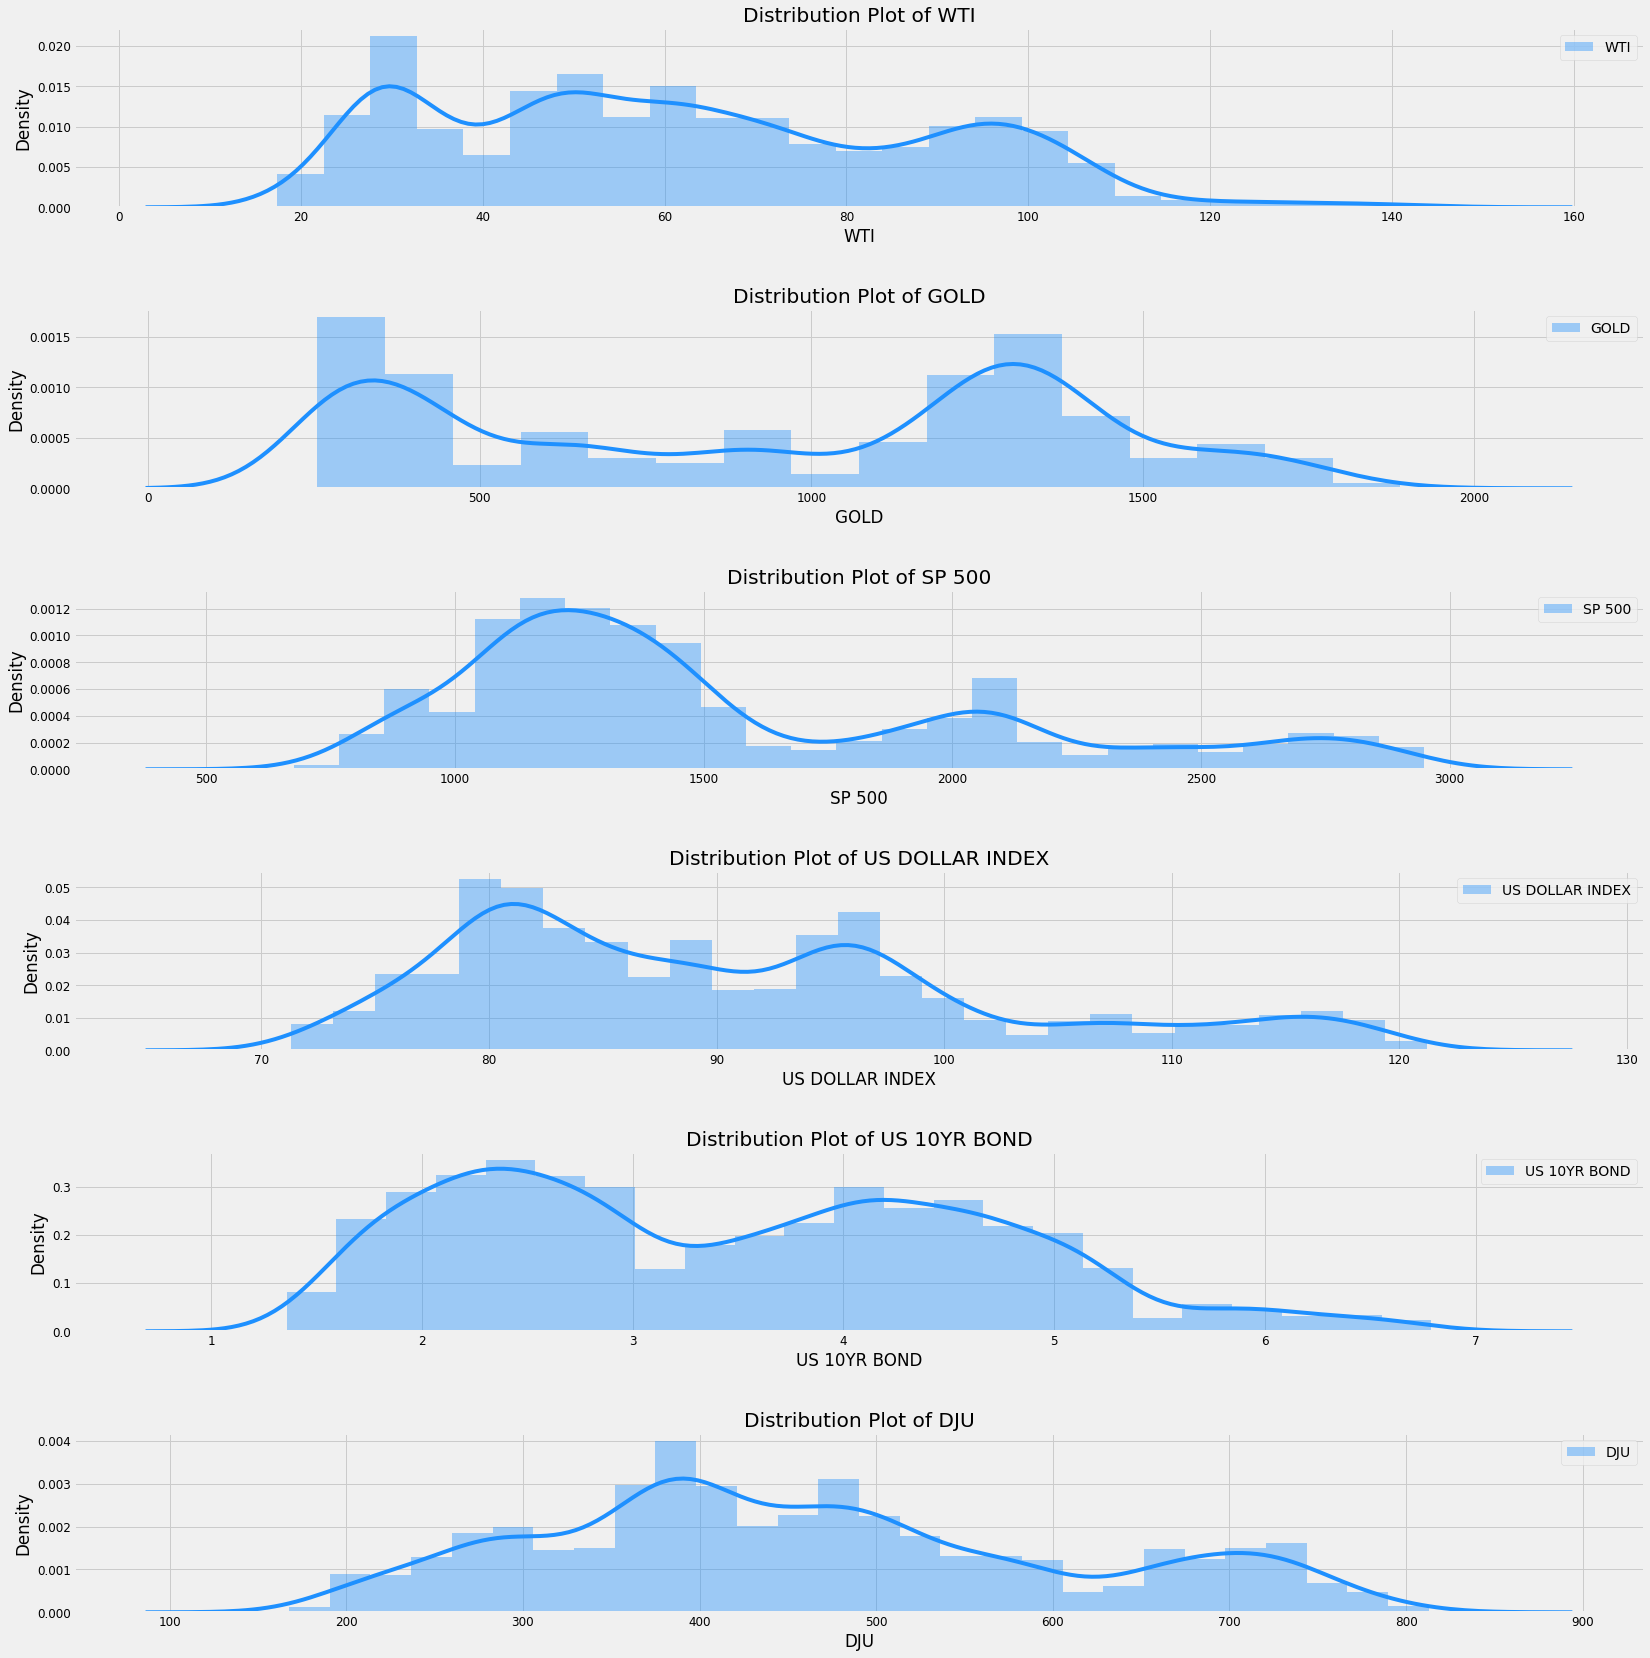

In [61]:
fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
col_names = df2.columns
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  sns.distplot(df2.iloc[:,i],label=col_names[i],color='dodgerblue').set_title("Distribution Plot of {}".format(col_names[i]),axes=ax)
  ax.tick_params(labelsize=12)
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

#### **Observations:** ###

1) WTI and other features do not follows normal distributions.

2) Most frequent values of WTI are in between 25 to 30.


## **Boxplot:** ##

In [62]:
trial_data= df2
trial_data['Year']= df2.index.year

Text(0.5, 1.0, 'Box Plot-WTI')

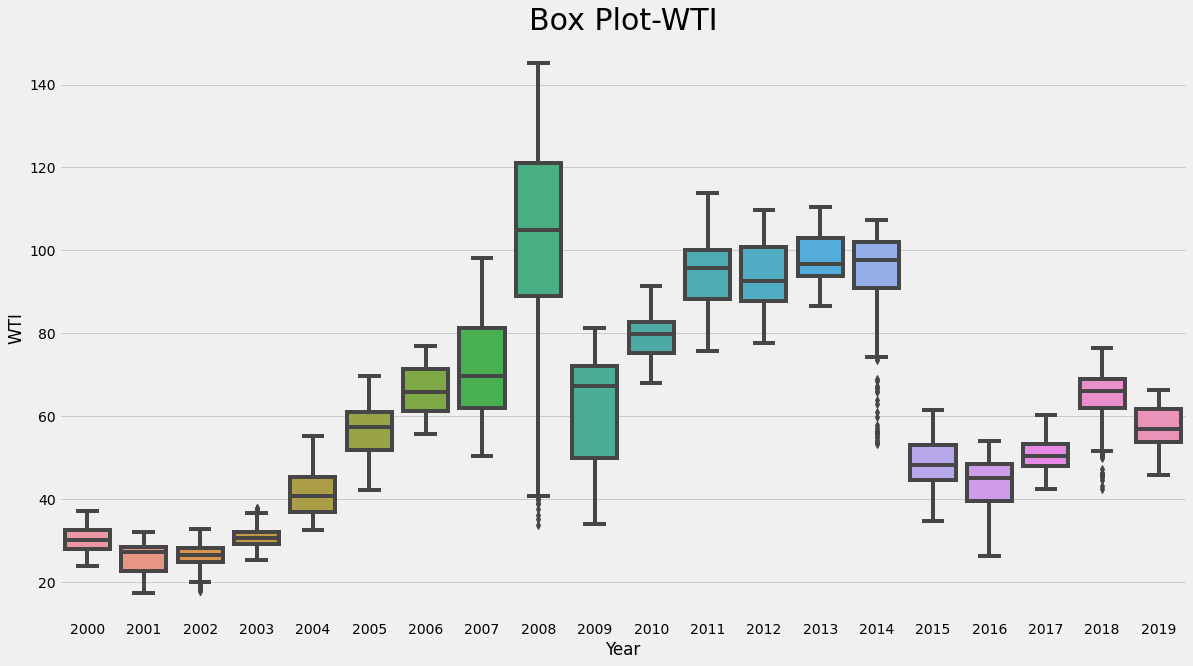

In [63]:
# Box plot year wise
plt.figure(figsize=(18,10))
ax = sns.boxplot(x=trial_data['Year'], y=trial_data['WTI'])
ax.set_title('Box Plot-WTI',fontsize=30)

### **Observations:** ###
1) During year 2007 to 2009 we see wide variation of values in WTI. We can consider this as outliers.

2) During year 2008, we see WTI oil price variation from $ 30 to 140 due to financial crisis.

### **Heatmap:** ###

Since Target and features dont follow normal distribution we will use spearman correlation.

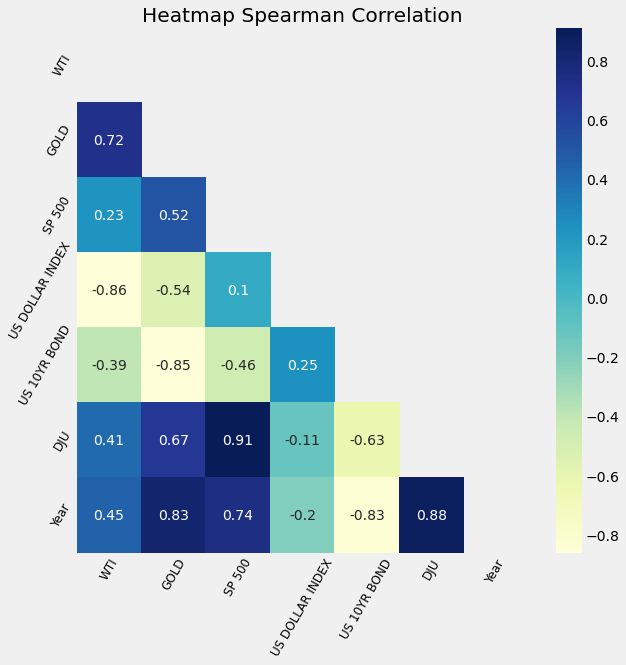

In [64]:
# HeatMap using Spearman Correlation
plt.figure(figsize=(9,9))
matrix = np.triu(df2.corr(method='spearman'))
heat_map = sns.heatmap(df2.corr(method='spearman'),annot=True,annot_kws={"size":14},cmap= 'YlGnBu',mask=matrix)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=60)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=60)
plt.tick_params(labelsize=12)
plt.title('Heatmap Spearman Correlation')
plt.style.use('fivethirtyeight')


## **Observations:** ##

1) WTI and gold has highest positive correlation 0.72.

2) US DOLLAR INDEX and US 10YR BOND	are inversely correlated to WTI. Also US DOLLAR INDEX have highest correlation -0.86.

3) SP500 and WTI has less correlation 0.23.

4) We observe high correlation between DJU and SP500 0.92.

5) There is multcollinearilty between DJU and [SP500, US 10YR BOND and GOLD ]

In [65]:
df2.corr(method= 'spearman')

,WTI,GOLD,SP 500,US DOLLAR INDEX,US 10YR BOND,DJU,Year
WTI,1.000000,0.720076,0.230186,-0.859079,-0.390108,0.413496,0.452737
GOLD,0.720076,1.000000,0.515117,-0.537962,-0.846502,0.669786,0.834237
SP 500,0.230186,0.515117,1.000000,0.104122,-0.460171,0.910919,0.744990
US DOLLAR INDEX,-0.859079,-0.537962,0.104122,1.000000,0.245306,-0.111127,-0.200841
US 10YR BOND,-0.390108,-0.846502,-0.460171,0.245306,1.000000,-0.626274,-0.828546
DJU,0.413496,0.669786,0.910919,-0.111127,-0.626274,1.000000,0.879780
Year,0.452737,0.834237,0.744990,-0.200841,-0.828546,0.879780,1.000000


## **Feature selection:** ##

We eliminate all features with spearman correlation less than 0.4. Also we removed multicollinearity by removing DJU. So we remained with GOLD, WTI and US DOLLAR INDEX.

In [66]:
zscore = np.abs(zs(df2['WTI']))
zscore_df = df2.copy()
zscore_df['zscore'] = zscore
zscore_df.head(5)

,WTI,GOLD,SP 500,US DOLLAR INDEX,US 10YR BOND,DJU,Year,zscore
Date,,,,,,,,
2000-01-04,25.55,282.7,1411.75,100.10,6.499,289.10,2000,1.379755
2000-01-05,24.91,281.1,1413.50,100.05,6.599,292.64,2000,1.403936
2000-01-06,24.78,281.4,1404.00,100.34,6.540,297.70,2000,1.408847
2000-01-07,24.22,281.9,1460.50,100.50,6.513,297.70,2000,1.430005
2000-01-10,24.67,281.7,1475.00,100.65,6.554,294.37,2000,1.413003


In [67]:
zscore_df = zscore_df.loc[zscore_df['zscore']<2.5,['WTI','GOLD','US DOLLAR INDEX']]
zscore_df.shape

(4910, 3)

In [68]:
zscore_df.head(2)

,WTI,GOLD,US DOLLAR INDEX
Date,,,
2000-01-04,25.55,282.7,100.10
2000-01-05,24.91,281.1,100.05


In [69]:
Train, Test= train_test_split(zscore_df, train_size= 0.65, shuffle= False)

In [70]:
print(Train.shape)
print(Test.shape)

(3191, 3)
(1719, 3)


In [71]:
scaler= MinMaxScaler(feature_range=(0,1))

In [72]:
def create_dataset(scaler, dataset, timesteps):
    input_d= scaler.fit_transform(dataset.values)
    X, Y= [], []
    for i in range(len(input_d)-timesteps-1):
        a= input_d[i:(i+timesteps), 0]
        X.append(a)
        Y.append(input_d[i+timesteps, 0])
    return np.array(X),  np.array(Y)

In [73]:
X_train, Y_train= create_dataset(scaler,Train,50)

In [74]:
X_test, Y_test= create_dataset(scaler,Test,50)

In [75]:
X_train.shape

(3140, 50)

In [76]:
Y_train.shape

(3140,)

In [77]:
clf= xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=100, subsample=0.4)

In [78]:
clf.fit(X_train, Y_train)

[12:42:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=10, subsample=0.4)

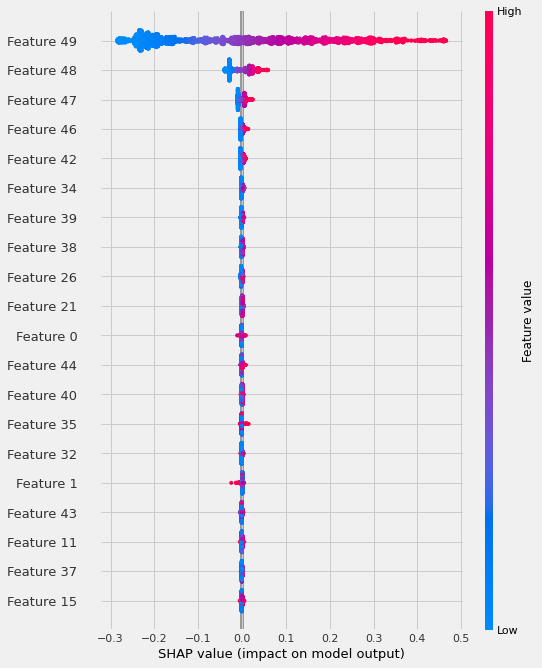

In [79]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

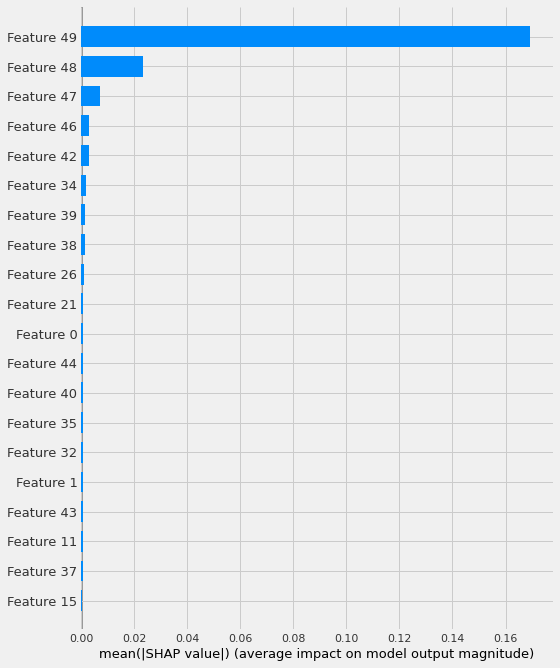

In [80]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

## **LSTM:** ##

In [81]:
def prepare_dataset(scaler,data,dim):
  Input= scaler.fit_transform(data.values)
  print('Shape of Input Data Initially',Input.shape)
  timesteps=50
  global X_1
  X_1 = []
  global Y_1
  Y_1=[]
  for i in range(len(Input)-timesteps-1):
    t=[]
    for j in range(0,timesteps):        
      
        t.append(Input[[(i+j)], :])
    X_1.append(t)
    Y_1.append(Input[i+ timesteps,0])
  
  X_1, Y_1= np.array(X_1), np.array(Y_1)
  print('Shape of  features after transformation',X_1.shape)
  print('Shape of Target after transformation ',Y_1.shape)
  
  X_1 = X_1.reshape(X_1.shape[0],timesteps, dim)
  print('Final Shape ',X_1.shape)
  return X_1,Y_1

In [82]:
X_train, Y_train= prepare_dataset(scaler,Train, 3)

Shape of Input Data Initially (3191, 3)
Shape of  features after transformation (3140, 50, 1, 3)
Shape of Target after transformation  (3140,)
Final Shape  (3140, 50, 3)


In [83]:
X_test, Y_test= prepare_dataset(scaler,Test, 3)

Shape of Input Data Initially (1719, 3)
Shape of  features after transformation (1668, 50, 1, 3)
Shape of Target after transformation  (1668,)
Final Shape  (1668, 50, 3)


**Model:**

In [105]:
Model=Sequential()
Model.add(LSTM(units=64, activation= 'relu', return_sequences=True,input_shape=(X_train.shape[1],3)))
Model.add(Dropout(0.2))
Model.add(LSTM(units=32, activation= 'relu', return_sequences=True,input_shape=(X_train.shape[1],3)))
Model.add(Dropout(0.2))
Model.add(LSTM(units=16, input_shape=(X_train.shape[1],3)))
Model.add(Dropout(0.2))
Model.add(Dense(units=1))
Model.compile(loss= tf.keras.losses.Huber(), metrics=['mae'], optimizer= 'adam')

In [107]:
Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50, 64)            17408     
                                                                 
 dropout_9 (Dropout)         (None, 50, 64)            0         
                                                                 
 lstm_10 (LSTM)              (None, 50, 32)            12416     
                                                                 
 dropout_10 (Dropout)        (None, 50, 32)            0         
                                                                 
 lstm_11 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [120]:
model= Model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_split=0.3, shuffle=False)

Epoch 1/200
69/69 [==============================] - 11s 154ms/step - loss: 0.0010 - mae: 0.0335 - val_loss: 0.0137 - val_mae: 0.1540
Epoch 2/200
69/69 [==============================] - 6s 86ms/step - loss: 0.0013 - mae: 0.0373 - val_loss: 0.0032 - val_mae: 0.0645
Epoch 3/200
69/69 [==============================] - 6s 88ms/step - loss: 0.0011 - mae: 0.0345 - val_loss: 0.0111 - val_mae: 0.1362
Epoch 4/200
69/69 [==============================] - 6s 88ms/step - loss: 0.0011 - mae: 0.0332 - val_loss: 0.0158 - val_mae: 0.1687
Epoch 5/200
69/69 [==============================] - 6s 89ms/step - loss: 9.6768e-04 - mae: 0.0330 - val_loss: 0.0133 - val_mae: 0.1519
Epoch 6/200
69/69 [==============================] - 6s 87ms/step - loss: 0.0016 - mae: 0.0395 - val_loss: 0.0025 - val_mae: 0.0562
Epoch 7/200
69/69 [==============================] - 6s 89ms/step - loss: 0.0011 - mae: 0.0337 - val_loss: 0.0151 - val_mae: 0.1607
Epoch 8/200
69/69 [==============================] - 7s 101ms/step - l

In [121]:
train_pred=Model.predict(X_train)

In [122]:
test_pred=Model.predict(X_test)

In [123]:
train_pred_copies= np.repeat(train_pred, 3, axis=-1)

In [124]:
test_pred_copies= np.repeat(test_pred, 3, axis=-1)

In [125]:
Y_train_pred= scaler.inverse_transform(train_pred_copies)[:, 0]

In [126]:
Y_test_pred= scaler.inverse_transform(test_pred_copies)[:, 0]

In [127]:
print(Y_train_pred.shape)
print(Y_test_pred.shape)

(3140,)
(1668,)


In [128]:
math.sqrt(mean_squared_error(Y_train, Y_train_pred))

64.79180495255585

In [129]:
math.sqrt(mean_squared_error(Y_test, Y_test_pred))

71.3839351685231